In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from mtcnn import mtcnn
import cv2

In [2]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray

In [3]:
a = np.load('train-data2.npz')
pictures, embeddings, names = a.f.arr_0, a.f.arr_1, a.f.arr_2

This is a picture of Chick_Hearn


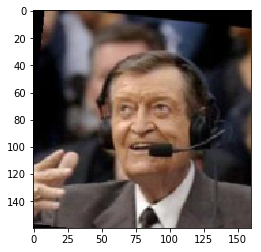

In [4]:
# Sanity check
pyplot.imshow(asarray(pictures[0]))
print('This is a picture of', names[0])

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation

In [6]:
model_file = 'model/facenet_keras.h5'
FRmodel = tf.keras.models.load_model(model_file)
# summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)
FRmodel.load_weights("model/facenet_keras_weights.h5")

# mark loaded layers as not trainable
for layer in FRmodel.layers:
  layer.trainable = False

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [7]:
def loss(y, yhat):
  return np.maximum(0, np.linalg.norm(y-yhat)-11)

def get_decoding_model():
  # define model
  model = Sequential()
  # define input shape, output enough activations for for 128 5x5 maps
  model.add(Dense(128 * 5 * 5, input_dim=128))
  # reshape vector of activations into 128 feature maps with 5x5
  model.add(Reshape((5, 5, 128)))
  # double inputto 64 10x10 feature map
  model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
  model.add(Conv2DTranspose(64, (3,3), strides=(1,1), padding='same'))

  model.add(BatchNormalization())

  # double input to 32 20x20 feature map
  model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
  model.add(Conv2DTranspose(32, (3,3), strides=(1,1), padding='same'))

  model.add(BatchNormalization())

  # double input to 16 40x40 feature map
  model.add(Conv2DTranspose(16, (3,3), strides=(2,2), padding='same'))
  model.add(Conv2DTranspose(16, (3,3), strides=(1,1), padding='same'))

  model.add(BatchNormalization())

  # double input to 4 80x80 feature map
  model.add(Conv2DTranspose(8, (3,3), strides=(2,2), padding='same'))
  model.add(Conv2DTranspose(8, (3,3), strides=(1,1), padding='same'))

  model.add(BatchNormalization())

  # double input to 1 160x160x3 feature map
  model.add(Conv2DTranspose(3, (3,3), strides=(2,2), padding='same'))

  # Apply sigmoid
  model.add(Activation('sigmoid'))

  # summarize model
  # model.summary()
  # print("input:",model.inputs)
  # model.outputs
  return model

# Pretrain decoding model on real image so initial training starts better for entire model
def pretrain_decoding_model(decoding_model):
  # instead of loss='mean_squared_error'
  decoding_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  decoding_model.fit(embeddings, pictures/256.0,
                     epochs=20,
                     batch_size=4)

def save_decoding_model(decoding_model):
    decoding_model.save("decoding_model.h5")

def combineModels(model1, model2):

  return Sequential([
    model1,
    model2
  ])

In [9]:
decoding_model = tf.keras.models.load_model('decoding_model.h5')#get_decoding_model()
decoding_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


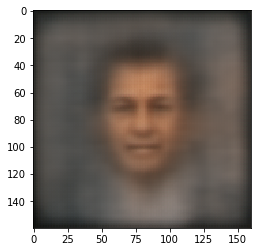

In [11]:
# Before pretraining (grey box):
test_image = decoding_model.predict(asarray([embeddings[0]]))
pyplot.imshow(test_image[0])

In [14]:
#pretrain_decoding_model(decoding_model)

Epoch 1/20
1800/1800 [==============================] - 7s 4ms/sample - loss: 0.0768 - acc: 0.5071
Epoch 2/20
1800/1800 [==============================] - 6s 3ms/sample - loss: 0.0676 - acc: 0.6413
Epoch 3/20
1800/1800 [==============================] - 6s 3ms/sample - loss: 0.0664 - acc: 0.6494
Epoch 4/20
1800/1800 [==============================] - 6s 3ms/sample - loss: 0.0659 - acc: 0.6508
Epoch 5/20
1800/1800 [==============================] - 6s 3ms/sample - loss: 0.0653 - acc: 0.6569
Epoch 6/20
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.0652 - acc: 0.6571
Epoch 7/20
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.0649 - acc: 0.6585
Epoch 8/20
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.0649 - acc: 0.6558
Epoch 9/20
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.0646 - acc: 0.6581
Epoch 10/20
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.0646 - acc: 0.6540
Epoch 11/

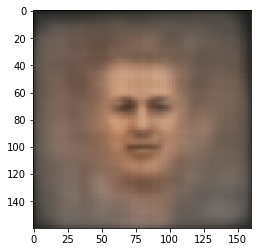

In [15]:
# Sanity check on first encoding:
test_image = decoding_model.predict(asarray([embeddings[11]]))
pyplot.imshow(test_image[0])

In [54]:
# Create our full model
# my_input = Input(shape=(128,))

In [12]:
# Create our full model
fullModel = Model(inputs=decoding_model.input, outputs=FRmodel(decoding_model.output))#combineModels(decoding_model, FRmodel)
fullModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
# Train our model
fullModel.fit(embeddings, embeddings,
              epochs=10,
              batch_size=16)

Epoch 1/10
 128/1800 [=>............................] - ETA: 21s - loss: 0.5077 - acc: 0.1484

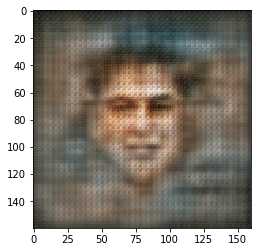

In [21]:
# Check progress!
test_image = decoding_model.predict(asarray([embeddings[200]]))
pyplot.imshow(test_image[0])

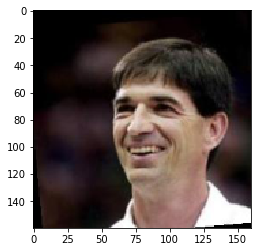

In [20]:
pyplot.imshow(pictures[200])

<tf.Tensor 'activation/Sigmoid:0' shape=(?, 160, 160, 3) dtype=float32>